## Auswertung der Bürgeramts-Recherche
Grundlage für die Analyse sind die Logs in den Ordnern "logs_id_card" und "logs_ummeldung". Diese enthalten die Ergebnisse eines Scrapers, der zwei Wochen lang nach Terminen gesucht hat - erst für die Anmeldung einer Wohnung, dann für die Beantragung eines Personalausweises. Die Beiden Ergebnisse sind sich außergewöhnlich ähnlich, da die beiden Dienstleistungen höchstwahrscheinlich auf den selben Terminpool zugreifen.Deshalb werden sie im Folgenden gemeinsam analysiert.


In [5]:
import numpy as np
import pandas as pd
import os
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import json
from collections import Counter, OrderedDict
from scipy.ndimage import uniform_filter1d
import re
import csv


def rolling_avg(input, kernel_size):
    return uniform_filter1d(input, kernel_size, mode="nearest")


fig_folder = "plots"


def figname(name):
    return os.path.join(fig_folder, name + ".png")

In [11]:
folders = ["logs_id_card", "logs_ummeldung"]

results_full = []

for folder_name in folders:
    for filename in os.listdir(folder_name):
        print("reading file: ", folder_name, filename)
        with open(os.path.join(folder_name, filename)) as f:
            data = json.load(f)
            results_full.extend(data)


results_full = np.array(sorted(results_full, key=lambda x: x["time"]))

for r in results_full:
    r["time"] = datetime.strptime(
        r["time"], "%Y-%m-%dT%H:%M:%SZ"
    )  # format string to datetime object
    if r["appts"] == []:
        r["appts"] = {}  # I did an oopsie during log generation, this line fixes that

    appts_formatted = []
    for date_str, timeslot_dict in r["appts"].items():
        date_formatted = datetime.strptime(date_str, "%Y-%m-%dT%H:%M:%SZ")
        if date_formatted.hour != 0:
            # Appointment dates were provided with some timing offset due to timezone/daylight savings
            # fixing this allows us to simply add the time of each appointment later on
            timezone_offset = 24 - date_formatted.hour
            date_formatted += timedelta(seconds=3600 * timezone_offset)

        if not len(timeslot_dict):
            appts_formatted.append([date_formatted, ""])
        else:
            # all this mess is necessary, because if two appts are presented at the same time
            # only the first one has a time specified in the table. Intuitive to read, but makes
            # for messy data.
            t_prev = None
            for t, location in timeslot_dict.items():
                if not t:
                    appt_time = t_prev
                else:
                    hours, mins = t.split(":")
                    appt_time = date_formatted + timedelta(
                        seconds=3600 * int(hours) + 60 * int(mins)
                    )
                    t_prev = appt_time
                appts_formatted.append([appt_time, location])
    r["appts"] = np.array(appts_formatted)

# make sure we only include exactly one week of data
start_idx, end_idx = None, None
for i, r in enumerate(results_full):
    if not start_idx and r["time"].hour == 0:
        start_idx = i

    if not end_idx and start_idx:
        if (r["time"] - results_full[start_idx]["time"]) > timedelta(weeks=2):
            end_idx = i
            break
results = results_full[start_idx:end_idx]

reading file:  logs_id_card log-2023-09-22.json
reading file:  logs_id_card log-2023-09-24.json
reading file:  logs_id_card log-2023-09-19.json
reading file:  logs_id_card log-2023-09-16.json
reading file:  logs_id_card log-2023-09-17.json
reading file:  logs_id_card log-2023-09-20.json
reading file:  logs_id_card log-2023-09-23.json
reading file:  logs_id_card log-2023-09-18.json
reading file:  logs_id_card log-2023-09-21.json
reading file:  logs_ummeldung log-2023-09-12.json
reading file:  logs_ummeldung log-2023-09-10.json
reading file:  logs_ummeldung log-2023-09-16.json
reading file:  logs_ummeldung log-2023-09-14.json
reading file:  logs_ummeldung log-2023-09-09.json
reading file:  logs_ummeldung log-2023-09-13.json
reading file:  logs_ummeldung log-2023-09-15.json
reading file:  logs_ummeldung log-2023-09-08.json
reading file:  logs_ummeldung log-2023-09-11.json


In [13]:
counts = Counter([e["msg"] for e in results])

all_msgs = [
    "Completed booking",
    "Failed at the last step",
    "Date but no timeslot",
    "Got a Captcha",
    "could not process response",
    "ERROR: 'NoneType' object is not subscriptable",
    "got nothing, appts today: ",
]
sucess_msgs = ["Completed booking", "Failed at the last step", "Date but no timeslot"]

n_offered_dates = (
    counts["Completed booking"]
    + counts["Failed at last step"]
    + counts["Date but no timeslots"]
)
n_finished_bookings = counts["Completed booking"]

print(f"Searched for appointments a total {len(results)} times.")
print(
    f'got {counts["Got a Captcha"]} Captchas ({100* counts["Got a Captcha"]/len(results):.2f}%)'
)
print(
    f"got offered at least one appt {n_offered_dates} times ({100* n_offered_dates/len(results):.2f}%)"
)
print(
    f"finished {n_finished_bookings} bookings ({100 * n_finished_bookings/len(results):.2f}%)"
)
print(f"-> {100*(1-n_finished_bookings/n_offered_dates):.2f}% appts got snatched away")

Searched for appointments a total 3909 times.
got 249 Captchas (6.37%)
got offered at least one appt 1631 times (41.72%)
finished 1333 bookings (34.10%)
-> 18.27% appts got snatched away


Total appts booked in two weeks (lower bound): 95331, appts per year: 2478606


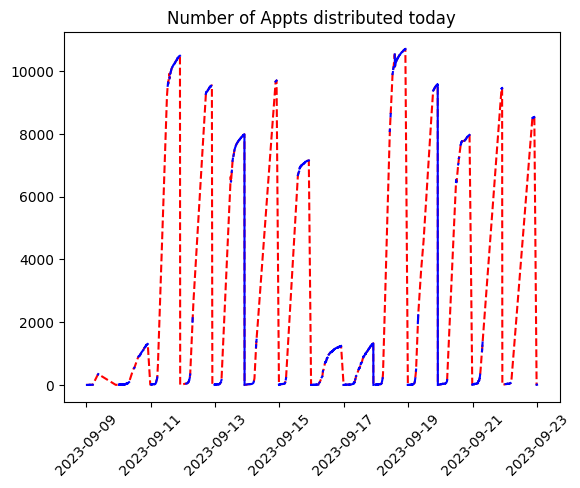

In [14]:
n_appts_cum = []
for r in results:
    msg = r["msg"]
    if msg.startswith("got nothing"):
        n_appts_cum.append(int(msg.split(":")[-1]))
    else:
        n_appts_cum.append(None)


n_appts_cum = np.array(n_appts_cum)
whr = np.where(n_appts_cum)[0]
interpolation_cum = np.interp(
    np.arange(len(results)), whr, n_appts_cum[whr].astype(int)
)

plt.title("Number of Appts distributed today")
results_times = [f["time"] for f in results]
plt.plot(results_times, interpolation_cum, color="red", linestyle="--")
plt.plot(results_times, n_appts_cum, color="blue")
plt.xticks(rotation=45)
plt.savefig(figname("n_appts_per_day"))

with open("n_appts_per_day.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Date", "data", "interpolation", "full"])
    for i in range(len(results)):
        writer.writerow(
            [
                results[i]["time"],
                n_appts_cum[i],
                interpolation_cum[i] if not n_appts_cum[i] else None,
                interpolation_cum[i],
            ]
        )

# this next section looks for the maximum value displayed in the counter each day, trying to estimate the total number of booked appointments each year.
daily_dict = {}
for ind, e in enumerate(results_times):
    d = e.day
    if d not in daily_dict:
        daily_dict[d] = []
    daily_dict[d].append(ind)

total_appts_per_day = {
    k: max([n_appts_cum[i] for i in v if n_appts_cum[i] is not None])
    for k, v in daily_dict.items()
}
total_appts_2_weeks = sum(total_appts_per_day.values())

print(
    f"Total appts booked in two weeks (lower bound): {total_appts_2_weeks}, appts per year: {total_appts_2_weeks*26}"
)

In [15]:

timeslots = OrderedDict()

for i in range(48):
    timeslots[time(hour=i//2, minute=30*(i%2))] = []


for r in results:
    t = r["time"]
    for t2 in timeslots.keys():
        if t.hour == t2.hour and t.minute < (t2.minute+30):
            timeslots[t2].append(r)
            break


# This next section looks at how likely it is to get an appointment on the same day, in the next two weeks, and in over two weeks. Results are stored to a .csv

n trials ('Got an appt'): 2.93, n events: 1333


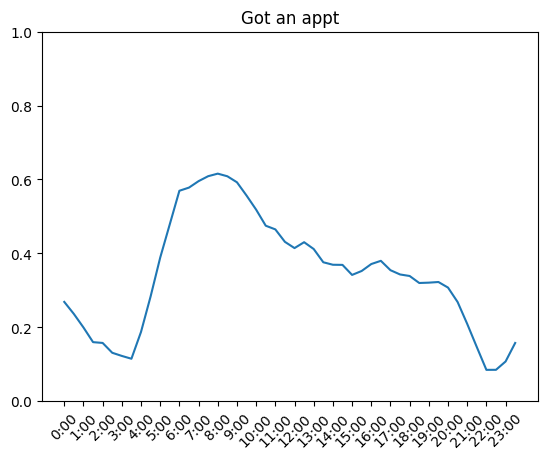

n trials ('In den nächsten zwei Wochen'): 12.82, n events: 305


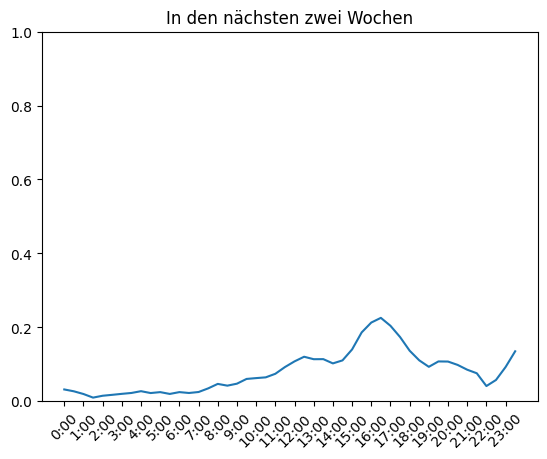

n trials ('Am selben Tag'): 10.15, n events: 385


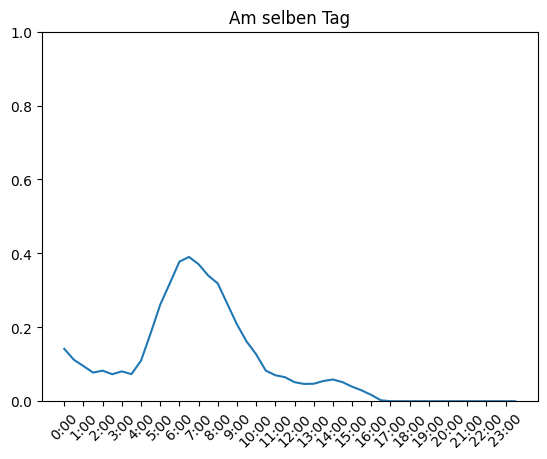

n trials ('In über zwei Wochen'): 6.08, n events: 643


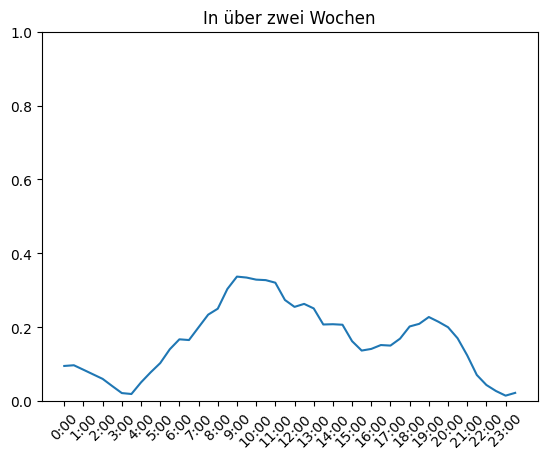

In [16]:
extracted_data = {}


def plot_half_hour_interval(keys, caption=None, filter_func=lambda x: True):
    """Generates a plot over a filtered subset of the data, presenting the likelyhood of finding an appointment that
    satisfies the given criteria. X-axis is time, divided into half-hour intervals over the day, y-axis is likelihood.

    Args:
        keys (list(str)): list of all return messages to be included
        caption (str, optional): caption of the figure. Defaults to None.
        filter_func (function, optional): filters dataset by a specified lambda (returning True or False). Defaults to lambda x:True.
    """

    keys_re = re.compile("|".join(keys), re.IGNORECASE)
    timeslots = OrderedDict()

    for i in range(48):
        timeslots[time(hour=i // 2, minute=30 * (i % 2))] = []

    for r in results:
        t = r["time"]
        for t2 in timeslots.keys():
            if t.hour == t2.hour and t.minute < (t2.minute + 30):
                timeslots[t2].append(r)
                break
    chance_per_timeslot = {}

    n_total = 0

    for k, v in timeslots.items():
        n_success = 0

        for log_dict in v:
            msg = log_dict["msg"]
            if re.search(keys_re, msg):
                if filter_func(log_dict):
                    n_success += 1

        chance_per_timeslot[k] = n_success / len(v)
        n_total += n_success

    fig, ax = plt.subplots()
    ax.plot(
        [f"{e.hour}:{e.minute}" for e in chance_per_timeslot.keys()],
        rolling_avg(list(chance_per_timeslot.values()), 5),
    )
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(24) * 2)
    ax.set_xticklabels([f"{i}:00" for i in np.arange(24)], rotation=45)

    if not caption:
        caption = keys_re.pattern
    ax.set_title(caption)
    print(
        f"n trials ('{caption}'): {1/(n_total/len(results)):.2f}, n events: {n_total}"
    )
    plt.savefig(figname(caption.replace(" ", "_")))
    plt.show()
    extracted_data[caption] = rolling_avg(list(chance_per_timeslot.values()), 5)


def filter_reasonable_time(log_dict):
    # not on the same day, but within 14 days
    appt_time = min(log_dict["appts"][:, 0])

    delta_t = appt_time - log_dict["time"]
    return (not appt_time.date() == log_dict["time"].date()) and delta_t.days < 14


def filter_today(log_dict):
    # on the same day
    appt_time = min(log_dict["appts"][:, 0])
    return appt_time.date() == log_dict["time"].date()


def filter_late(log_dict):
    # over two weeks in the future
    appt_time = min(log_dict["appts"][:, 0])
    delta_t = appt_time - log_dict["time"]
    return delta_t.days >= 14


plot_half_hour_interval(["Completed booking"], "Got an appt")
plot_half_hour_interval(
    ["Completed booking"], "In den nächsten zwei Wochen", filter_reasonable_time
)
plot_half_hour_interval(["Completed booking"], "Am selben Tag", filter_today)
plot_half_hour_interval(["Completed booking"], "In über zwei Wochen", filter_late)


# store extracted data to csv 
columns = ["time"]
data_arr = [[e.strftime("%H:%M") for e in timeslots.keys()]]

for k, v in extracted_data.items():
    columns.append(k)
    data_arr.append(np.round(v * 100, 2))


with open("appointment_chance_halfhour.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(columns)
    data_arr = np.array(data_arr)
    for i in range(data_arr.shape[1]):
        writer.writerow(data_arr[:, i])

n trials ('could not process response'): 10.26, n events: 381


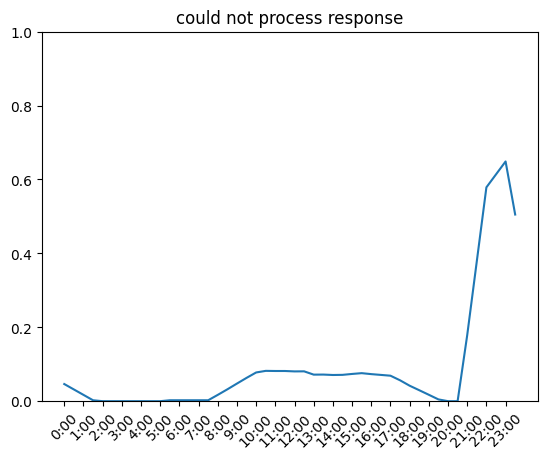

n trials ('Failed at the last step|Date but no timeslot'): 26.59, n events: 147


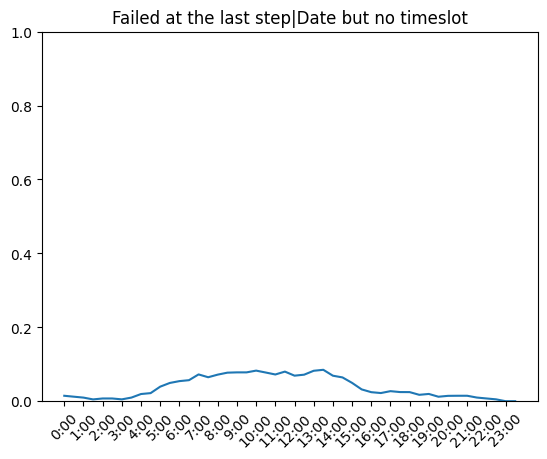

n trials ('Got a Captcha'): 15.70, n events: 249


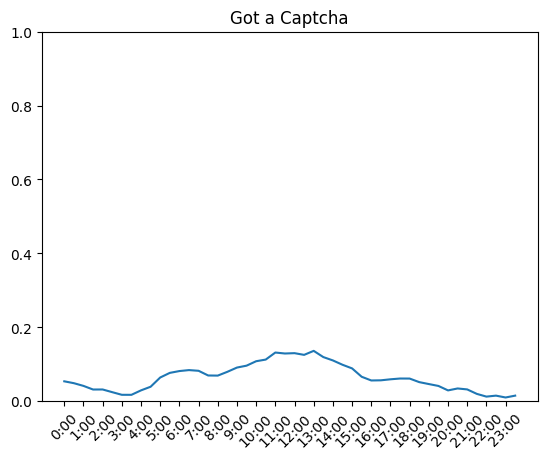

In [17]:
# some more plots
plot_half_hour_interval(["could not process response"])
plot_half_hour_interval(all_msgs[1:3])
plot_half_hour_interval(["Got a Captcha"])

# Next we look more closely at all of the attempts in which an appointment was presented. Extracted information is: How far in the future is the appt? What time of day? What Bürgeramt? Vorzugstermin or regular?

13604/21580 (63.04%) of all appts were 'Vorzugstermine'


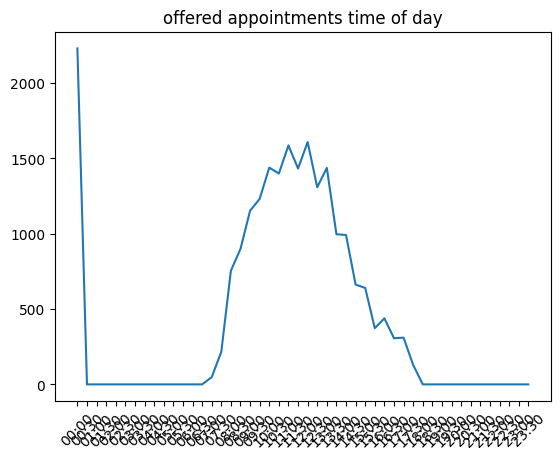

In [18]:
appt_timedeltas = []
timedeltas_vorzug = []
timedeltas_regular = []
appt_times = []
locations = []


for log_dict in results_full:
    # iterate over all attempts
    if len(log_dict["appts"]):  # if any appt was found
        for t_appt, location in log_dict["appts"]:
            locations.append(location)
            appt_times.append(time(hour=t_appt.hour, minute=t_appt.minute))

            delta_t = t_appt - log_dict["time"]
            appt_timedeltas.append(delta_t)
            if re.search("Vorzugstermine", location):
                timedeltas_vorzug.append(delta_t)
            else:
                timedeltas_regular.append(delta_t)

n_vorzug = len(timedeltas_vorzug)
n_total = len(timedeltas_regular) + n_vorzug
print(
    f"{n_vorzug}/{n_total} ({(100*n_vorzug/n_total):.2f}%) of all appts were 'Vorzugstermine'"
)

timeslots = {}
for i in range(48):
    timeslots[time(hour=i // 2, minute=30 * (i % 2))] = []


for t in appt_times:
    for t2 in timeslots.keys():
        if t.hour == t2.hour and t.minute < (t2.minute + 30):
            timeslots[t2].append(t)
            break

max_days = max([dt.days for dt in appt_timedeltas])
counts, bins, bars = plt.hist(
    [e.days + e.seconds / (3600 * 24) for e in appt_timedeltas],
    bins=(max_days + 1) * 2,
    range=(0, max_days + 1),
)

with open("timedeltas.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["count", "time [days]"])
    writer.writerows(zip(counts, bins))

plt.clf()
plt.plot(
    [t.strftime("%H:%M") for t, loc in timeslots.items() if loc != ""],
    [len(e) for e in timeslots.values()],
)
plt.xticks(rotation=45)
plt.title("offered appointments time of day")
plt.savefig(figname("appt_time"))
plt.show()

# This cell computes the Bürgerämter that provided the most appointments. The first row without a label is the sum of all attempts to book that only got a date, but not a timeslot

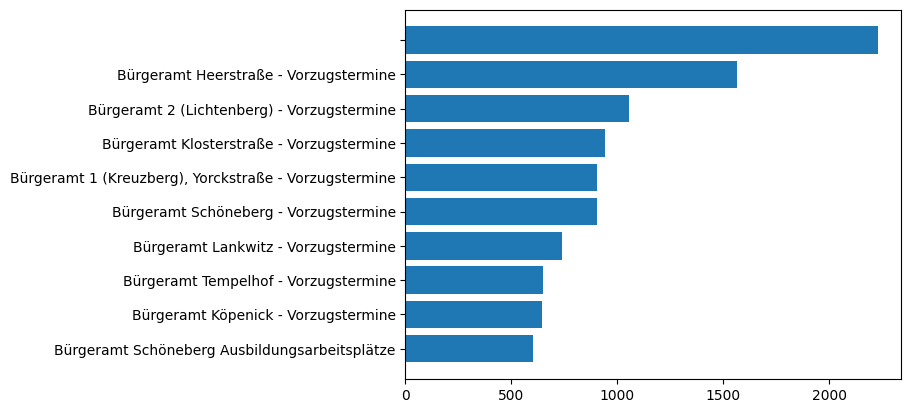

In [19]:
loc_counter = Counter(locations)
plt.barh(*zip(*loc_counter.most_common(10)[::-1]))
plt.show()

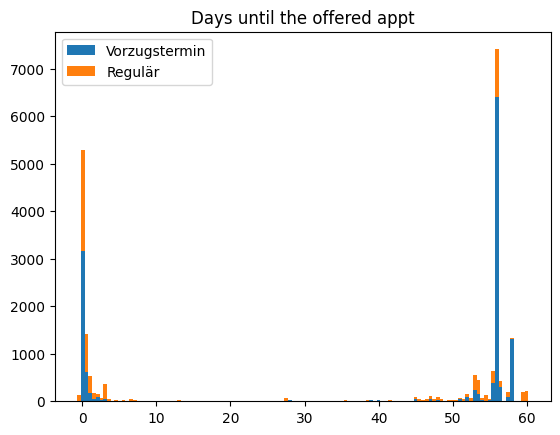

In [20]:
hist_array = [
    [e.days + e.seconds / (3600 * 24) for e in timedeltas_vorzug],
    [e.days + e.seconds / (3600 * 24) for e in timedeltas_regular],
]

plt.hist(
    hist_array,
    bins=(max([dt.days for dt in appt_timedeltas]) + 1) * 2,
    stacked=True,
    label=["Vorzugstermin", "Regulär"],
)
plt.title("Days until the offered appt")
plt.legend()
plt.savefig(figname("days_unit_appt"))
plt.show()

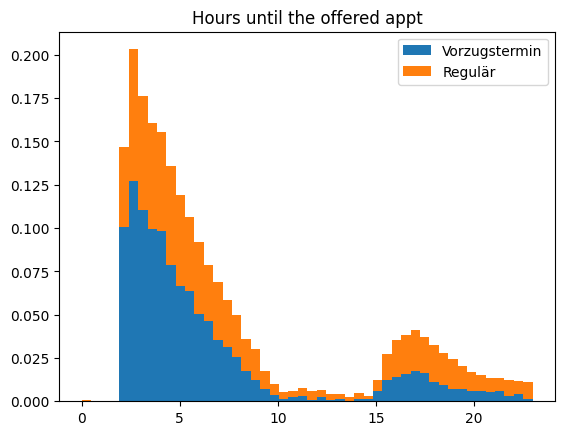

In [21]:
hist_array = [
    [e.seconds / 3600 for e in timedeltas_vorzug if e.days < 1],
    [e.seconds / 3600 for e in timedeltas_regular if e.days < 1],
]

plt.hist(
    hist_array,
    stacked=True,
    density=True,
    label=["Vorzugstermin", "Regulär"],
    bins=48,
    range=(0, 23),
)
plt.title("Hours until the offered appt")
plt.legend()
plt.savefig(figname("hours_unit_appt"))
plt.show()

In [22]:
with open("bezirksaemter.json", "r") as f:
    bezirksaemter_dict = json.load(f)

bezirksaemter_counter = {k: 0 for k in bezirksaemter_dict.keys()}

not_found = []

for l in locations:
    if not len(l):
        continue
    for k, v in bezirksaemter_dict.items():
        if l in v:
            bezirksaemter_counter[k] = bezirksaemter_counter[k] + 1
            break
    else:
        print(f"could not find a matching Bezirk for: {l}")
        not_found.append(l)

In [23]:
with open("bezirke_n_appts.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(["Bezirk", "Anzahl an Terminen"])
    for k,v in bezirksaemter_counter.items():
        writer.writerow([k,v])

In [ ]:
bezirke_stats = pd.read_csv(
    "berzirke_population.csv"
)
bezirke_stats = bezirke_stats.set_index("Bezirk")
bezirke_stats = bezirke_stats.drop(
    [
        "darunter mit Migrationshintergrund",
        "Anteil Einwohner mit Migrationshintergrund %",
        "Sozial-Index",
    ], axis=1
)
bezirke_stats["appts"] = np.nan
bezirke_stats["Einwohner"] = (
    bezirke_stats["Einwohner"].apply(lambda x: x.replace(" ", "")).astype(int)
)
# Inhabitants in the different Bezirke
# from https://download.statistik-berlin-brandenburg.de/1ed2bda91b255dd1/9efa16b6afd4/SB_A01-05-00_2023h01_BE.pdf


for k, v in bezirksaemter_counter.items():
    bezirke_stats.loc[k, "appts"] = v

bezirke_stats["appts_relative"] = bezirke_stats["appts"] / bezirke_stats["Einwohner"]
bezirke_stats.to_csv("bezirke_n_appts.csv")